# Make a dust continuum image and SED
In this tutorial you will see how to use disc2radmc to create all the input files that radmc3d needs to run and how to run radmc3d to produce dust images and a spectral energy distribution (SED).

In [1]:
import numpy as np
import disc2radmc 
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

We start by defining what the surface density of dust will be. This is defined as a function that receives the cylindrical `r` and `phi` as the first arguments, followed by any argument that defines the surface density. This doesn't need to be normalized as that will be done internally for each dust species. This function must be able to receive ndarray's for r and phi. 

Below an example of a surface density that is a Gaussian radially, but varies azimuthally as sin(phi)

In [2]:
def Sigma_dust(r, phi, rc, sigr, phi0):
    
    return np.exp( -0.5 * ((r-rc)/sigr)**2.)*(1.+np.sin(phi-phi0))

We now define the parameters that will define our model. Note that many of these parameters don't need to be defined and they will be set to default values. However, it is better to know how to change these if your model is more complicated.

In [3]:
########################
###### PARAMETERS ######
########################

## STAR
Rstar=1.0 # [Solar radii]
Tstar= 5800 # [K] If this is negative, the code will consider the star as a blackbody. For a realistic stellar model, you can download bt-settl models and indicate their directory later
dir_stellar_templates='/Users/Sebamarino/Astronomy/Stellar_templates/BT-Settl/bt-settl/'
dpc=50.  # [pc] distance to source 
target='my_favourite_disc'# name

## DUST
Mdust=0.5      # [Mearth] Total dust mass
rc=100.        # [au]
sigr=20.       # [au]
phi0=np.pi/2. # [rad]
amin=1.0       # [mu]  minimum grain size (1 by default)
amax=1.0e4     # [mu]  maximum grain size (1e4 by default)
N_species=1    #  (1 by default) Number of dust size bins to use for the radiative transfer calculations. 
slope = -3.5   #  (-3.5 by default) Slope of the size distribution. This is used for computing opacities and for the mass distribution of each size bin
h=0.05         # vertical aspect ratio =H/r, where H is the vertical standard deviation. This is a constant, but other parametrizations are possible and will be shown below. 
par_sigma=(rc, sigr, phi0) # list containing the parameters that define the dust surface density. They must be in the same order as in the definition of Sigma_dust

## MODEL SPATIAL GRID
rmin=1. # [au] make sure it is small enough to sample the surface density
rmax=300.# [au] 
Nr=100    # radial cells (linearly or logspaced)
Nphi=100 # azimuthal cells
Nth=10   # polar angle cells
thmax=np.arctan(h)*5 # maximum polar angle to sample as measured from the midplane.
axisym=False # Consider the disc to be axisymmetric to speed up calculations? it can overwrite Nphi if True and set it to 1
mirror=True  # Mirror the upper half to speed up calculations. This is incompatible with anisotropic scattering.
logr=True # Sample r logarithmically or linearly

# WAVELENGTH GRID (grid to sample the stellar flux in temperature calculations, see radmc3d manual)
lammin=0.09  # [mu]  minimum wavelength to consider in our model (important for temperature calculation)
lammax=1.0e5 # [mu] minimum wavelength to consider in our model (important for temperature calculation)
Nlam=150     # number of cells logarithmically spaced to sample the wavelength range.

# IMAGE PARAMETERS
Npix=512  # number of pixels
dpix=0.02 # pixel size in arcsec
inc=45.    # inclination
PA=90.    # position angle

wavelength=880. # [um] image wavelength
scattering_mode=1 # scattering mode (0=no scattering, 1=isotropic, 2=anisotropic using H&G function)



Our model will be made of multiple objects that we need to define and save for radmc3d: 
- Spatial grid
- Wavelength grid
- Star
- Dust

In [4]:
### PHYSICAL GRID
gridmodel=disc2radmc.model.physical_grid(rmin=rmin, rmax=rmax, Nr=Nr, Nphi=Nphi, Nth=Nth, thmax=thmax, mirror=mirror, logr=logr, axisym=axisym)
gridmodel.save()

### WAVELENGTH GRID
lammodel=disc2radmc.model.wavelength_grid(lammin=lammin, lammax=lammax, Nlam=Nlam)
lammodel.save()

### STAR
starmodel=disc2radmc.model.star(lammodel, Tstar=Tstar, Rstar=Rstar,
                               #dir_stellar_templates=dir_stellar_templates # necessary if Tstar>0
                               )
starmodel.save()


For the dust, we will mix the optical constants of three species (astrosilicates, amorphous carbon and water ice) using the Bruggeman rule.

In [5]:
### DUST SIZE DISTRIBUTION AND OPACITY
# path to optical constants that can be found in https://github.com/SebaMarino/disc2radmc/tree/main/opacities/dust_optical_constants
path_opct='/Users/Sebamarino/Astronomy/Codes/disc2radmc/opacities/dust_optical_constants/' 
lnk_files=[path_opct+'astrosilicate_ext.lnk',
           path_opct+'ac_opct.lnk',
           path_opct+'ice_opct.lnk']
densities=[4., 3., 1.] # densities in g/cm3
mass_weights=[70.0, 15., 15.] # mixing ratios by mass
dust=disc2radmc.model.dust(lammodel,
                           Mdust=Mdust,
                           lnk_file=lnk_files,
                           densities=densities,
                           N_species=N_species,
                           slope=slope,
                           N_per_bin=100, # number of species per size bin to have a good representation 
                           mass_weights=mass_weights,
                           tag='mix', # name to give to this new mixed species
                           compute_opct=True) 

Compute average optical constants
final density = 2.7 g/cm3


Now we will compute the opacity using the Mie theory by Craig F. Bohren and Donald R. Huffman. You need to download it from http://scatterlib.wdfiles.com/local--files/codes/bhmie-f.zip, unzip, compile using with `make` from your terminal, and copy the file `makeopac` to your working directory. Then you can compute the opacities as `dust.compute_opacities()` which will produce one or a set of files containing the opacities of the N_species dust species. This might take a while, so you probably want to comment that line after computing your final opacities.

In [6]:
dust.compute_opacities()

We now define our dust densities in each cell of the spatial grid and save this for radm3d.

In [7]:
### DUST DENSITY DISTRIBUTION
dust.dust_densities(grid=gridmodel,function_sigma=Sigma_dust, par_sigma=par_sigma, h=h)
dust.write_density()

# Now, let's run radmc3d
We start by specifying some parameters for RADMC3D. We proceed computing the temperature with the thermal montecarlo simulation. Then we will compute an image, and finally an SED.

In [8]:
sim=disc2radmc.model.simulation(nphot=10000000, # number of photon packages for thermal monte carlo
                                nphot_scat=1000000, # number of photon packages for image
                                nphot_spec=10000,   # number of photon packages for spectrum
                                nphot_mono=10000,   # number of photon packages for the monochromatic monte carlo
                                scattering_mode=scattering_mode, 
                                incl_lines=0, # whether to include gas lines (1) or not (0)
                                modified_random_walk=0, # for very optically thick medium, this is a useful approximation
                                istar_sphere=0, # consider the star a sphere or a point.
                                tgas_eq_tdust=1, # gas temperature equal to the temperature of the first dust species
                                setthreads=4,
                                verbose=True, 
                               )

### RUN MCTHERM to compute temperature
sim.mctherm()

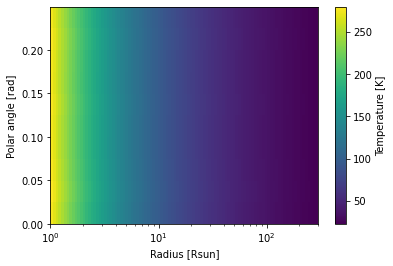

In [9]:
# check temperature
Ts=np.fromfile('./dust_temperature.bdat', count=gridmodel.Nr*gridmodel.Nphi*gridmodel.Nth+4, dtype=float)[4:].reshape( (gridmodel.Nphi, gridmodel.Nth, gridmodel.Nr))
plt.pcolormesh(gridmodel.redge, gridmodel.thedge, Ts[0,:,:])
plt.xlabel('Radius [Rsun]')
plt.xscale('log')
plt.ylabel(r'Polar angle [rad]')
plt.colorbar(label='Temperature [K]')
plt.show()

# Let's make some images

In [10]:
### MAKE IMAGE
sim.simimage(dpc=dpc, 
             imagename='test1', 
             wavelength=wavelength,
             Npix=Npix,
             dpix=dpix,
             inc=inc,
             PA=PA,
             tag=target)

#             background_args=[bg1, bg2, bg3])

image size = 5.1e+02 au
radmc3d image incl 45.00000  phi  0.00000 posang 0.00000  npix 512  lambda 880.00000 sizeau 512.00000  secondorder


Let's plot the image that is now saved at ./images/image_test1_my_favourite_disc.fits

Total flux = 22.756 mJy


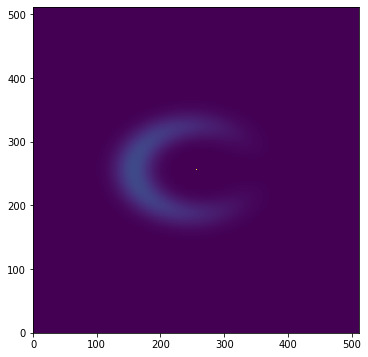

In [11]:
fit1=pyfits.open('./images/image_test1_my_favourite_disc.fits')
image=fit1[0].data[0,0,:,:]
print('Total flux = %1.3f mJy'%(np.sum(image)*1.0e3))
fig=plt.figure(figsize=(6,6))
ax1=fig.add_subplot(111)
ax1.pcolormesh(image)
ax1.set_aspect('equal')

There are other functionalities that might result useful.

For example, you can pad the image and increase its size. This can be useful when your source is small but you still need a large image, for example, to compute its visibilities. In this case, you can specify the size of your final image with Npixf as shown below.

In [12]:
Npixf=1024
sim.simimage(dpc=dpc, 
            imagename='test2', 
            wavelength=wavelength,
            Npix=Npix,
            Npixf=Npixf,
            dpix=dpix,
            inc=inc,
            PA=PA,
            tag=target,
            )

#background_args=[bg1, bg2, bg3]

image size = 5.1e+02 au
radmc3d image incl 45.00000  phi  0.00000 posang 0.00000  npix 512  lambda 880.00000 sizeau 512.00000  secondorder


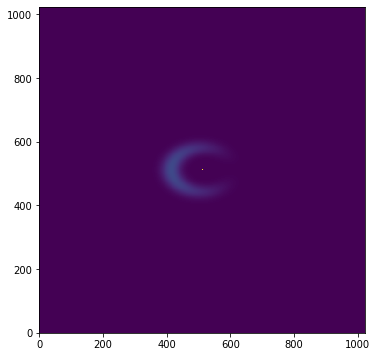

In [13]:
fit1=pyfits.open('./images/image_test2_my_favourite_disc.fits')
image=fit1[0].data[0,0,:,:]

fig=plt.figure(figsize=(6,6))
ax1=fig.add_subplot(111)
ax1.pcolormesh(image)
ax1.set_aspect('equal')

You can also take this image and scale it to another wavelength using a spectral index of 2 for the central star, and a uniform  spectral index for the dust. This is faster than computing the image again and allows to fit alpha_dust instead of varying the dust size distribution/opacity parameters.

In [14]:
alpha_dust=2.5 # dust spectral index
new_wavelength=1300. # [um] wavelength of new image 
path_image='image_test2_'+target+'.out' # path to image previously computed by radmc3d
path_fits='images/image_test2_alpha_'+target+'.fits' # name of new fits image that will be created

disc2radmc.model.convert_to_fits(path_image,
                                 path_fits,
                                 Npixf,
                                 dpc,
                                 tag=target,
                                 alpha_dust=alpha_dust,
                                 new_lambda=new_wavelength)


You can also specify the flux of the central star, and add other sources in the image defined as elliptical Gaussians.

In [15]:
fstar=0.0 # if <1 it does not change the stellar flux

# Let's add three background objects. They are specify as arrays with the following parameters
# [number of image pixels, pixel size, flux_jy, ra_offset_arcsec, dec_offset_arcsec, major_std_arcsec, minor_std_arcsec, PA)
bg1=[Npixf, dpix, 5.0e-3, -8., 8., 1., 0.5, 45.] # 
bg2=[Npixf, dpix, 5.0e-3, 4., -4., 1., 0.5, 45.]
bg3=[Npixf, dpix, 5.0e-3, -2., 2., 1., 0.5, 45.]

sim.simimage(dpc=dpc, 
            imagename='test3', 
            wavelength=wavelength,
            Npix=Npix,
            Npixf=Npixf,
            dpix=dpix,
            inc=inc,
            PA=PA,
            tag=target,
            background_args=[bg1, bg2, bg3],
            fstar=fstar)

image size = 5.1e+02 au
radmc3d image incl 45.00000  phi  0.00000 posang 0.00000  npix 512  lambda 880.00000 sizeau 512.00000  secondorder


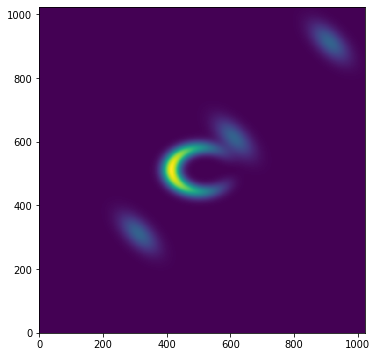

In [16]:
fit1=pyfits.open('./images/image_test3_my_favourite_disc.fits')
image=fit1[0].data[0,0,:,:]

fig=plt.figure(figsize=(6,6))
ax1=fig.add_subplot(111)
ax1.pcolormesh(image)
ax1.set_aspect('equal')

Finally, you can define more exotic vertical distributions. First let's change the aspect ratio $h$ as a function of $r$ such that
$$ H(r) = h r_0 (r/r_0)^{\gamma}$$
We will also make the disc wider, axisymmetric and more inclined to see the effect

In [17]:
def Sigma_dust(r, phi, rc, sigr):
    return np.exp( -0.5 * ((r-rc)/sigr)**2.)

# radial parameters
rc=100.
sigr=50.
par_sigma=(rc, sigr)

# vertical parameters
h=0.1
r0=rc # reference radius
gamma=3.

dust.dust_densities(grid=gridmodel,function_sigma=Sigma_dust, par_sigma=par_sigma,
                    h=h,
                    r0=r0,
                    gamma=gamma)
dust.write_density()


image size = 5.1e+02 au
radmc3d image incl 90.00000  phi  0.00000 posang 0.00000  npix 512  lambda 880.00000 sizeau 512.00000  secondorder


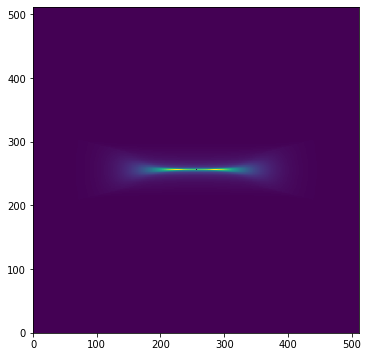

In [18]:
### MAKE IMAGE
sim.simimage(dpc=dpc, 
             imagename='test4', 
             wavelength=wavelength,
             Npix=Npix,
             dpix=dpix,
             inc=90.,
             PA=PA,
             tag=target,
             fstar=0.)

fit1=pyfits.open('./images/image_test4_my_favourite_disc.fits')
image=fit1[0].data[0,0,:,:]

fig=plt.figure(figsize=(6,6))
ax1=fig.add_subplot(111)
ax1.pcolormesh(image)
ax1.set_aspect('equal')

We can even define functions for the vertical distribution that are different from a Gaussian, as long as they are correctly normalized and can be defined as a function of z and H. Note that in this case H is simply a reference height and it can be a constant or vary with r by changing `gamma`. The vertical distribution function (called `rho_exotic` below), needs to be in units of 1/au.


In [19]:
def rhoz_exotic(z, H):
    return 0.5*( np.exp(-(z-2*H)**2.0/(2.0*H**2.0))/(np.sqrt(2.0*np.pi)*H)+np.exp(-(z+2*H)**2.0/(2.0*H**2.0))/(np.sqrt(2.0*np.pi)*H) )
def Sigma_dust(r, phi, rc, sigr):
    return np.exp( -0.5 * ((r-rc)/sigr)**2.)

# radial parameters
rc=100.
sigr=50.
par_sigma=(rc, sigr)

# vertical parameters
h=0.05
r0=rc # reference radius
gamma=1.

dust.dust_densities(grid=gridmodel,function_sigma=Sigma_dust, par_sigma=par_sigma,
                    h=h,
                    r0=r0,
                    gamma=gamma,
                    functions_rhoz=[rhoz_exotic],
                   )
dust.write_density()

image size = 5.1e+02 au
radmc3d image incl 90.00000  phi  0.00000 posang 0.00000  npix 512  lambda 880.00000 sizeau 512.00000  secondorder


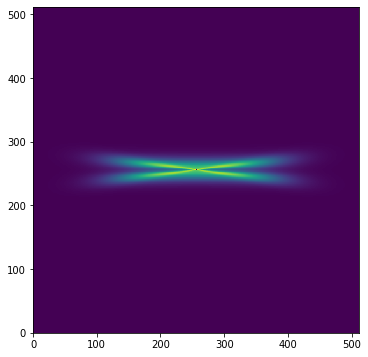

In [20]:
### MAKE IMAGE
sim.simimage(dpc=dpc, 
             imagename='test5', 
             wavelength=wavelength,
             Npix=Npix,
             dpix=dpix,
             inc=90.,
             PA=PA,
             tag=target,
             fstar=0.)

fit1=pyfits.open('./images/image_test5_my_favourite_disc.fits')
image=fit1[0].data[0,0,:,:]

fig=plt.figure(figsize=(6,6))
ax1=fig.add_subplot(111)
ax1.pcolormesh(image)
ax1.set_aspect('equal')

# Let's make an SED

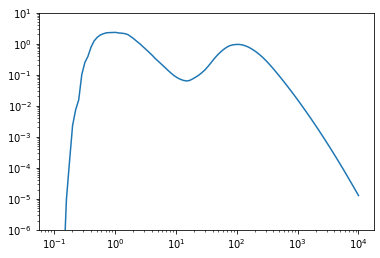

In [23]:
### make sed
wavelengths=np.logspace(-1,4, 100)  # um
sed=sim.simsed(wavelengths=wavelengths, dpc=dpc, inc=inc)

## plot sed
plt.plot(sed[:,0], sed[:,1])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.0e-6, 10.0)
plt.show()
